In [197]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import sys

In [198]:
with open('raman.txt') as f:
    lines = f.readlines()

raw = [l.strip().split('\t') for l in lines]
data = np.array([list(map(float, i)) for i in raw])

In [199]:
rel_peak_indices = find_peaks(data[:, 1], prominence=1000)[0]
rel_peak_vals = np.take(data[:, 1], rel_peak_indices)

sub_peak = data[:, 1][np.logical_and(2750 <= data[:, 0], data[:, 0] <= 3000)]

rel_peak_indices_sub_peak = find_peaks(sub_peak, prominence=100)[0]
rel_peak_vals_sub_peak = np.take(sub_peak, rel_peak_indices_sub_peak)
rel_peak_indices_sub_peak = np.delete(rel_peak_indices_sub_peak, 0)
rel_peak_vals_sub_peak = np.delete(rel_peak_vals_sub_peak, 0)

sub_peak_indices = np.array([np.where(np.isclose(data[:, 1], val))[0][0] for val in rel_peak_vals_sub_peak])
combined_indices = np.unique(np.append(rel_peak_indices, sub_peak_indices))

sorted_peak_vals = np.flip(np.sort(np.unique(np.append(rel_peak_vals, rel_peak_vals_sub_peak))))[:8]

peak_val_ind_map = {i:(data[:, 0][i], val) for i, val in product(combined_indices, sorted_peak_vals) if np.isclose(data[:, 1][i], val)}

### Note: To find the peaks, I first looked at the overall plot to find clear peaks in the data, but noticed that this did not include the subpeaks within the region of around 2750 to 3000 for the wavenumber. As you can see in the plot in part b), the peaks were clustered closer together than the other ones. However, I still decided that these could qualify as peaks as they were far enough away from each other and included them as such. From there I included the highest eight peaks which included a number of these peaks.

In [200]:
n_vals = np.array([5, 15, 25])
regions = {}
for n, idx in product(n_vals, peak_val_ind_map):
    sub_region_wave_nums = data[:, 0][np.logical_and(peak_val_ind_map[idx][0]-n <= data[:, 0], data[:, 0] <= peak_val_ind_map[idx][0]+n)]
    sub_region_intensities = data[:, 1][np.logical_and(peak_val_ind_map[idx][0]-n <= data[:, 0], data[:, 0] <= peak_val_ind_map[idx][0]+n)]
    sub_region_indices = [np.where(np.isclose(data[:, 0], val))[0][0] for val in sub_region_wave_nums]
    regions[(n, data[:, 1][idx])] = (sub_region_indices, sub_region_wave_nums, sub_region_intensities)

maximums = {}
for key, val in regions.items():
    maximums[key[1]] = []

splines = []
for key, val in regions.items():
    x_axis = val[1]
    y_axis = val[2]

    f = UnivariateSpline(x_axis, y_axis, k=4)
    x = np.linspace(np.amin(x_axis), np.amax(x_axis), 1000)

    roots = f.derivative().roots()
    max_val = np.amax(f(roots))
    max_root = roots[np.isclose(f(roots), max_val)]
    maximums[key[1]].append((key[0], max_root[0], max_val))

    splines.append((f, key[0], max_root[0], max_val))

# Part a)

In [201]:
best_estimates = []
for key, val in maximums.items():
    curr_max = (0, 0, 0)
    final_max = (0, 0, 0)
    for v in val:
        if v[2] > curr_max[2] and v[2] <= np.amax(data[:, 1]) + np.std(data[:, 1]):
            curr_max = v
    final_max = curr_max    
    best_estimates.append(final_max)

intensities = []
for e in best_estimates:
    intensities.append(e[2])

sorted_intensities = sorted(intensities)
sorted_intensities.reverse()

wave_nums = []
for a, b in product(sorted_intensities, best_estimates):
    if np.isclose([a], [b[2]]):
        wave_nums.append(b[1])

for w in wave_nums:
    sys.stdout.write(str(w) + '\n')

750.2632340340632
1251.0748851558621
2975.7801309531865
2947.841576332076
2884.524463011936
1031.8852876804492
1427.1656235223797
1145.434659064874


# Part b)

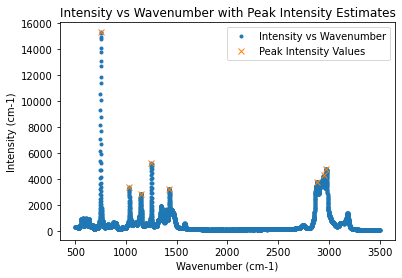

In [202]:
plt.plot(data[:, 0], data[:, 1], '.')
plt.plot(wave_nums, sorted_intensities, 'x')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity (cm-1)')
plt.legend(['Intensity vs Wavenumber', 'Peak Intensity Values'])
plt.title('Intensity vs Wavenumber with Peak Intensity Estimates')
plt.show()

# Part c)

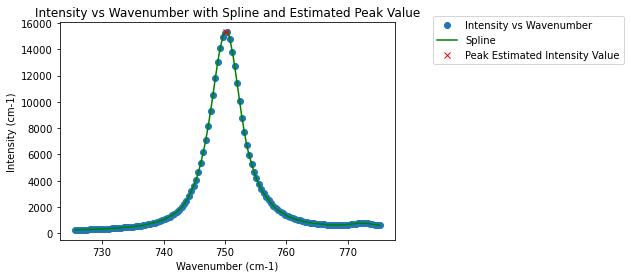

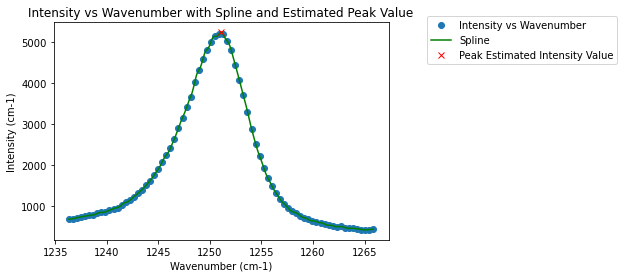

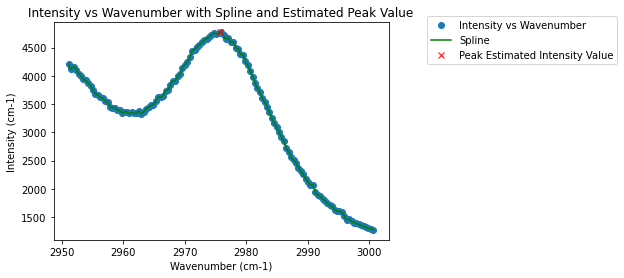

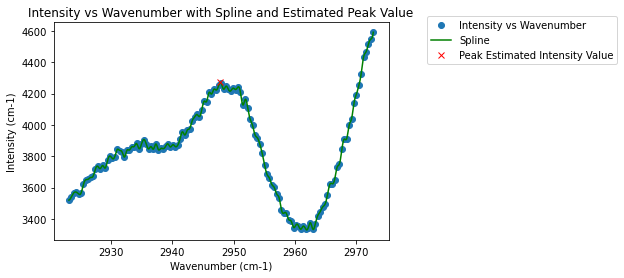

In [207]:
top_four_wavenums = wave_nums[:4]
top_four_intensities = sorted_intensities[:4]

top_four_peaks = []
for b in best_estimates:
    if b[1] in top_four_wavenums:
        top_four_peaks.append((b[0], b[1], b[2]))

top_four_peaks.sort(key=lambda x:x[2])
top_four_peaks.reverse()

four_peak_regions = {}
for p in top_four_peaks:
    sub_region_wave_nums = data[:, 0][np.logical_and(p[1]-p[0] <= data[:, 0], data[:, 0] <= p[1]+p[0])]
    sub_region_intensities = data[:, 1][np.logical_and(p[1]-p[0] <= data[:, 0], data[:, 0] <= p[1]+p[0])]
    four_peak_regions[(p[0], p[1], p[2])] = (sub_region_wave_nums, sub_region_intensities)

for key, val in four_peak_regions.items():
    x_axis = val[0]
    y_axis = val[1]
    max_wave_num = key[1]
    max_intensity = key[2]

    for f in splines:
        if np.isclose([f[3]], max_intensity) and f[1] == key[0]:
            x = np.linspace(np.amin(x_axis), np.amax(x_axis), 1000)

            plt.figure()
            plt.plot(x_axis, y_axis, 'o')
            plt.plot(x, f[0](x), 'g')
            plt.plot(max_wave_num, max_intensity, 'rx')
            plt.xlabel('Wavenumber (cm-1)')
            plt.ylabel('Intensity (cm-1)')
            plt.legend(['Intensity vs Wavenumber', 'Spline', 'Peak Estimated Intensity Value'], bbox_to_anchor=(1.1, 1.05))
            plt.title('Intensity vs Wavenumber with Spline and Estimated Peak Value')

plt.show()